In [1]:
import h5py
import cupy as cp
import pandas as pd
import numpy as np

In [2]:
f = h5py.File('./data/data_git_version.h5', 'r')
data = f['data']
data = cp.array(data)
f.close()
#读取.\data\crawled_feature.csv
df = pd.read_csv('./data/crawled_feature.csv')


In [39]:
#取出data中的（1，10000，3）的数据
data1 = data[1, :, :]
print(data1.shape)
print(df.shape)
#将data1和df合并为(10000,7)
data1 = cp.asnumpy(data1)
data1 = np.hstack((data1, df))
print(data1.shape)



(10000, 3)
(10000, 4)
(10000, 7)


(7, 7)


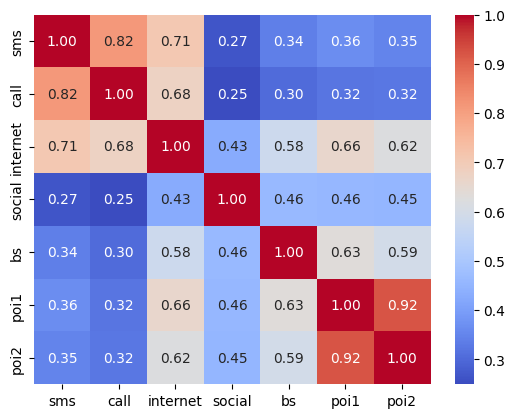

In [19]:
#计算data1的相关性
corr = np.corrcoef(data1, rowvar=0)
print(corr.shape)
import seaborn as sns
import matplotlib.pyplot as plt
#画出相关性热力图
#添加横纵坐标
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',xticklabels=('sms','call','internet','social','bs','poi1','poi2'),yticklabels=('sms','call','internet','social','bs','poi1','poi2'))
plt.show()


In [3]:
#将df转为cp.array
df = cp.array(df)
print(df.shape)
datan=[]
for i in range(1488):
    datan.append(df)
datan = cp.array(datan)
print(datan.shape)
#查看datan的type
print(type(datan))



(10000, 4)
(1488, 10000, 4)
<class 'cupy._core.core.ndarray'>


In [4]:
#将data（1488，10000，3）和datan（1488，10000，4）合并为（1488，10000，7）
print(type(data))
print(type(datan))
data = cp.concatenate((data,datan), axis=-1)
print(data.shape)


<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
(1488, 10000, 7)


In [7]:
trainlist=data[0:100,:,:]
testlist=data[100:120,:,:]
print(trainlist.shape)
print(testlist.shape)

(100, 10000, 7)
(20, 10000, 7)


In [22]:
#滑窗
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for j in range(dataset.shape[0]-look_back):
            a = dataset[j:(j+look_back),:,:]
            dataX.append(a)
            dataY.append(dataset[j + look_back,:,:])
    return cp.array(dataX), cp.array(dataY)
look_back = 3
trainX,trainY  = create_dataset(trainlist,look_back)
testX,testY = create_dataset(testlist,look_back)
trainY = cp.reshape(trainY[:,:,1], (trainY.shape[0], trainY.shape[1],1))
testY = cp.reshape(testY[:,:,1], (testY.shape[0], testY.shape[1],1))
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(97, 3, 10000, 7)
(97, 10000, 1)
(17, 3, 10000, 7)
(17, 10000, 1)


In [19]:
print(len(trainX.shape))

4


In [26]:
def reshape_data(data):
    #计算data的有几维
    dim = len(data.shape)
    if dim==4 : 
        data=cp.reshape(data,(data.shape[0],data.shape[1],100,100,data.shape[3]))
    else: 
        data=cp.reshape(data,(data.shape[0],100,100,data.shape[2]))
    return data
trainX = reshape_data(trainX)
trainY = reshape_data(trainY)
testX = reshape_data(testX)
testY = reshape_data(testY)
print(trainX.shape)
print(trainY.shape)

(97, 3, 100, 100, 7)
(97, 100, 100, 1)


In [29]:
#将数据保存为h5文件
f = h5py.File('./data/trainlist.h5', 'w')
f.create_dataset('trainX', data=trainX[:,:,40:60,40:60,:].get())
f.create_dataset('trainY', data=trainY[:,40:60,40:60,:].get())
f.close()
f = h5py.File('./data/testlist.h5', 'w')
f.create_dataset('testX', data=testX[:,:,40:60,40:60,:].get())
f.create_dataset('testY', data=testY[:,40:60,40:60,:].get() )
f.close()